# Final Group Project

## Brain MRI Tumor Classification with Transfer Learning

## Problem Overview

Brain tumors are a major medical concern, and early detection through MRI imaging significantly improves treatment outcomes. Manual diagnosis is time-consuming and requires specialized expertise. This motivates the use of automated image-classification systems.

### Learning Problem

We formulate tumor detection as a **binary supervised classification** task:

- **Input:** A single brain MRI scan (grayscale or RGB formatted).  
- **Output:** A categorical label:
  - `1` → Tumor present  
  - `0` → No tumor

### Why CNNs?

MRI images contain spatial features (textures, shapes, edges). Convolutional Neural Networks (CNNs) are highly effective for spatial feature extraction.  
Given limited compute, we use **transfer learning** with a pretrained ResNet18 model, adapting its final classification layer for our dataset.

This allows:
- Faster convergence  
- Less required data  
- Strong accuracy with modest resources

### Dataset Description
#### Dataset link: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

We use the publicly available “Brain MRI Images for Brain Tumor Detection” dataset by Navoneel Chakrabarty, hosted on Kaggle. 
The dataset contains 253 labeled MRI images, each stored as a 2D grayscale slice. The images are divided into two classes:

1. 155 images labeled “yes” - MRI scans containing a tumor
2. 98 images labeled “no” - MRI scans without a tumor

Each image shows an axial cross-section of the brain. The images vary in resolution and lighting conditions, making them suitable for evaluating the robustness of deep learning models.

#### Preprocessing Steps
Before training, we apply the following preprocessing operations:
1. Resize all images to 224×224 pixels to match the input requirements of ResNet-18.
2. Normalize pixel intensities using ImageNet mean and standard deviation, as required for transfer learning.
3. Convert each image into PyTorch tensors.
4. Data augmentation applied only to the training set:
    - Random rotations
    - Horizontal flips

### Data Splitting
To evaluate the model fairly, the dataset is divided into:
1. 70% Training Set
2. 15% Validation Set
3. 15% Test Set

Splits are performed within each class to maintain class balance across subsets.

In [1]:
import os
import random
import shutil
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Set device and seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

Using device: cpu


## Create train/val/test splits

In [ ]:
DATA_ROOT = Path("../data/raw/brain-mri") 
SPLIT_ROOT = Path("../data/processed") # create new folder with train/val/test

In [ ]:
# Create empty folder structure for each split and each class
for split in ["train", "val", "test"]:
    for cls in ["yes", "no"]:
        (SPLIT_ROOT / split / cls).mkdir(parents=True, exist_ok=True)

"""
    Split all images from DATA_ROOT/<class_name> into train/val/test subsets
    according to the provided ratios, and copy them into:
      - ../data/processed/train/<class_name>/
      - ../data/processed/val/<class_name>/
      - ../data/processed/test/<class_name>/
    This keeps the splits stratified by class.
"""
def split_class_folder(class_name, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    src_dir = DATA_ROOT / class_name
    images = [f for f in src_dir.iterdir() if f.suffix.lower() in [".jpg", ".jpeg", ".png"]]
    images.sort()
    n = len(images)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)
    # remaining goes to test
    random.shuffle(images)

    train_files = images[:n_train]
    val_files = images[n_train:n_train+n_val]
    test_files = images[n_train+n_val:]

    for f in train_files:
        shutil.copy(f, SPLIT_ROOT / "train" / class_name / f.name)
    for f in val_files:
        shutil.copy(f, SPLIT_ROOT / "val" / class_name / f.name)
    for f in test_files:
        shutil.copy(f, SPLIT_ROOT / "test" / class_name / f.name)

    print(class_name, "->", len(train_files), "train,", len(val_files), "val,", len(test_files), "test")

# Create splits for both classes: 'yes' (tumor) and 'no' (no tumor)
split_class_folder("yes")
split_class_folder("no")

yes -> 108 train, 23 val, 24 test
no -> 68 train, 14 val, 16 test


## Define transforms & DataLoaders

We’ll use data augmentation on train and simple resizing on val/test. We’ll leverage ImageNet normalization since we’re using a pretrained model.

In [ ]:
# Hyperparameters for image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 16

# Data augmentation + normalization for training set
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet normalization (required for pretrained ResNet)
        std=[0.229, 0.224, 0.225]
    )
])

# For validation and test we only resize + normalize (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Wrap the folder structure into PyTorch datasets
train_dataset = datasets.ImageFolder(SPLIT_ROOT / "train", transform=train_transform)
val_dataset   = datasets.ImageFolder(SPLIT_ROOT / "val", transform=val_test_transform)
test_dataset  = datasets.ImageFolder(SPLIT_ROOT / "test", transform=val_test_transform)

# Create DataLoaders to feed data in mini-batches during training/evaluation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_dataset.classes
print("Classes:", class_names)
print("Train size:", len(train_dataset), "Val size:", len(val_dataset), "Test size:", len(test_dataset))


Classes: ['no', 'yes']
Train size: 249 Val size: 97 Test size: 102


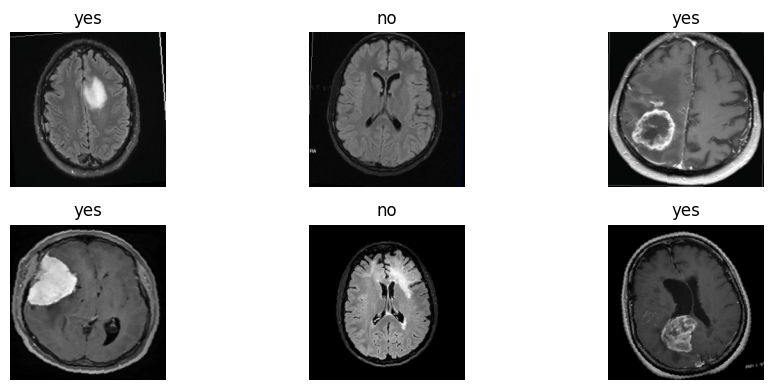

In [ ]:
def imshow_tensor(img_tensor):
    """
        Undo normalization on a tensor image and display it using matplotlib.
    """
    img = img_tensor.clone().detach()
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")

data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow_tensor(images[i])
    plt.title(class_names[labels[i]])
plt.tight_layout()
plt.show()

## Neural Network Architecture (ResNet18 with Transfer Learning)

We use **ResNet18**, a pretrained convolutional neural network with ~11M parameters.

### Why ResNet18?

- Lightweight and fast to train  
- Skip connections prevent vanishing gradients  
- Strong baseline performance on image tasks  
- Ideal for binary medical imaging classification with limited compute  

### Architecture Modifications

We replace the final fully-connected layer:

Original:
`fc: 512 → 1000`

Modified:
`fc: 512 → 2`

This allows the model to output probabilities for our two classes.


In [ ]:
from torchvision.models import resnet18, ResNet18_Weights


# Load ResNet18 with weights pretrained on ImageNet
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)

# Replace the final fully connected layer to output a single logit for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # 1 output logit for binary classification

model = model.to(device)

# Print parameter counts to understand model capacity
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\mathu/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:03<00:00, 14.5MB/s]


Total parameters: 11,177,025
Trainable parameters: 11,177,025


In [ ]:
# Define loss, optimizer, scheduler

# BCEWithLogitsLoss combines a sigmoid layer + binary cross-entropy in a numerically stable form.
# It expects raw logits as model output and targets in {0,1}.
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer on all trainable parameters
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# StepLR: decay learning rate by factor 0.1 every 5 epochs to help convergence
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 

## Training & validation loops

We’ll write helper functions for one epoch train and one epoch eval.

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Run one full training epoch over the given DataLoader.
    Returns average loss and accuracy over the epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation + parameter update
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # predictions: sigmoid + threshold 0.5
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()
        correct += (preds.cpu().squeeze(1) == labels.cpu().long().squeeze(1)).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).long()

            correct += (preds.cpu().squeeze(1) == labels.cpu().long().squeeze(1)).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy().flatten().tolist())
            all_preds.extend(preds.cpu().numpy().flatten().tolist())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_preds)

In [ ]:
# Main training loop over multiple epochs
NUM_EPOCHS = 15

# Track the best validation accuracy to later restore the best model
best_val_acc = 0.0
best_model_state = None

# History dict to store metrics for plotting
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Save the weights of the model that performs best on the validation set
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} "
          f"- Train loss: {train_loss:.4f}, acc: {train_acc:.4f} "
          f"- Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

print("Best val acc:", best_val_acc)

Epoch 01/15 - Train loss: 0.4642, acc: 0.8112 - Val loss: 0.2150, acc: 0.9588
Epoch 02/15 - Train loss: 0.1843, acc: 0.9398 - Val loss: 0.0896, acc: 0.9794
Epoch 03/15 - Train loss: 0.0935, acc: 0.9799 - Val loss: 0.0470, acc: 0.9897
Epoch 04/15 - Train loss: 0.0655, acc: 0.9839 - Val loss: 0.0572, acc: 0.9794
Epoch 05/15 - Train loss: 0.0808, acc: 0.9679 - Val loss: 0.0293, acc: 0.9897
Epoch 06/15 - Train loss: 0.0491, acc: 0.9839 - Val loss: 0.0234, acc: 0.9897
Epoch 07/15 - Train loss: 0.0435, acc: 0.9880 - Val loss: 0.0192, acc: 0.9897
Epoch 08/15 - Train loss: 0.0147, acc: 1.0000 - Val loss: 0.0214, acc: 0.9897
Epoch 09/15 - Train loss: 0.0427, acc: 0.9880 - Val loss: 0.0204, acc: 0.9897
Epoch 10/15 - Train loss: 0.0175, acc: 1.0000 - Val loss: 0.0165, acc: 0.9897
Epoch 11/15 - Train loss: 0.0141, acc: 1.0000 - Val loss: 0.0127, acc: 1.0000
Epoch 12/15 - Train loss: 0.0178, acc: 1.0000 - Val loss: 0.0177, acc: 0.9897
Epoch 13/15 - Train loss: 0.0240, acc: 1.0000 - Val loss: 0.0240

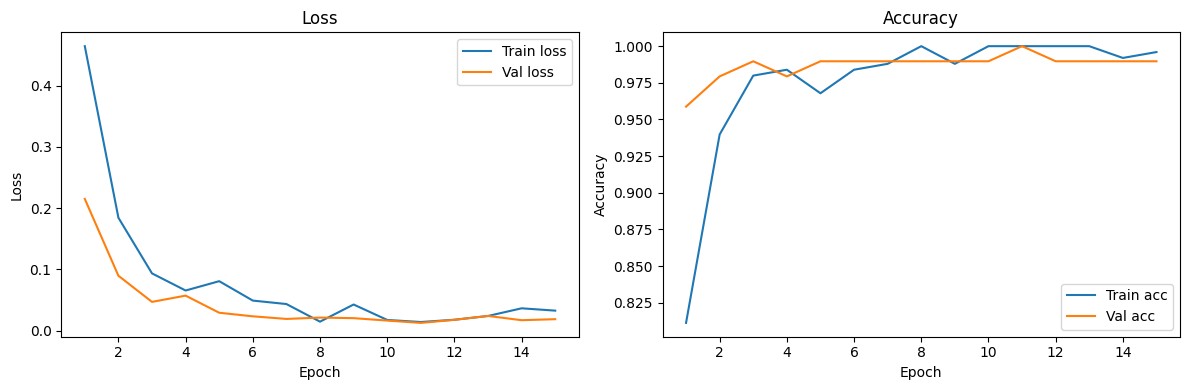

In [ ]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train acc")
plt.plot(epochs, history["val_acc"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.show()

## Final evaluation on test set

Use the best validation model for test evaluation.

In [ ]:
# Load best weights from training (highest validation accuracy)
model.load_state_dict(best_model_state)

# Evaluate once on the held-out test set
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion, device)

print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

Test loss: 0.0195, Test acc: 0.9902

Classification report:
              precision    recall  f1-score   support

          no       0.98      1.00      0.99        42
         yes       1.00      0.98      0.99        60

    accuracy                           0.99       102
   macro avg       0.99      0.99      0.99       102
weighted avg       0.99      0.99      0.99       102

Confusion matrix:
 [[42  0]
 [ 1 59]]


In [ ]:
# Save the best-performing model weights to disk.
# This .pt file is later loaded by our deployment app to serve predictions on new MRI images.
MODEL_PATH = "brain_tumor_resnet18.pt"
torch.save(best_model_state, MODEL_PATH)
print("Saved model to", MODEL_PATH)

Saved model to brain_tumor_resnet18.pt
